In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib.image as mpimg

def show_amazonas(imagen_RGB):
    """
    Muestra la imagen RGB compuesta de la Amazonía con zoom progresivo desde una coordenada inicial.

    Args:
        imagen_RGB (ndarray): Imagen RGB compuesta.
        x0 (int): Coordenada inicial en el eje x.
        y0 (int): Coordenada inicial en el eje y.
    """
    niveles_zoom = [
        {"tamaño": 3000, "x0": 2000, "y0": 2000},  # Nivel 1: Recorte amplio
        {"tamaño": 1000, "x0": 3000, "y0": 3000},  # Nivel 2: Recorte medio
        {"tamaño": 500, "x0": 3000, "y0": 3250}    # Nivel 3: Recorte detallado
    ]

    plt.figure(figsize=(15, 15))
    for i, zoom in enumerate(niveles_zoom, start=1):
        tamaño = zoom["tamaño"]
        x1 = zoom["x0"] + tamaño
        y1 = zoom["y0"] + tamaño
        x1 = min(x1, imagen_RGB.shape[1])
        y1 = min(y1, imagen_RGB.shape[0])

        recorte = imagen_RGB[zoom["y0"]:y1, zoom["x0"]:x1]

        plt.subplot(1, 3, i)
        plt.imshow(recorte, origin='upper')
        plt.axis('off')
        plt.title(f"Zoom Nivel {i} ({tamaño}x{tamaño})", fontsize=14)

    plt.tight_layout()
    plt.show()

def calibrate_imag(imagen, metadato, U='T'):
    """
    Calibra la imagen basada en los metadatos de GOES-16.

    Args:
        imagen (ndarray): Datos de la imagen sin procesar.
        metadato (dict): Metadatos asociados con la imagen.
        U (str): Unidad de salida ('T' para temperatura, 'Rad' para radiancia, 'Ref' para reflectancia).

    Returns:
        ndarray: Imagen calibrada.
    """
    canal = int(metadato['band_id'][:])
    if canal >= 7 and U == 'T':
        # Calibración a temperatura de brillo
        fk1 = metadato['planck_fk1'][0]
        fk2 = metadato['planck_fk2'][0]
        bc1 = metadato['planck_bc1'][0]
        bc2 = metadato['planck_bc2'][0]

        imagen = np.where(imagen > 0, imagen, np.nan) 
        imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1) / bc2 - 273.15 
    elif U == 'Rad':
        # Calibración a radiancia
        pendiente = metadato['Rad'].scale_factor
        ordenada = metadato['Rad'].add_offset
        imag_cal = imagen * pendiente + ordenada
    elif U == 'Ref':
        # Calibración a reflectancia
        kapa0 = metadato['kappa0'][0].data
        imag_cal = kapa0 * imagen
    else:
        raise ValueError(f"Unidad de calibración '{U}' no reconocida. Use 'T', 'Rad' o 'Ref'.")

    return imag_cal

def realce_gama(V, A, gamma, Vmin, Vmax):
    """
    Aplica el realce de gamma a una imagen o matriz de datos.

    Args:
        V (ndarray): Matriz de datos de entrada.
        A (float): Amplitud de salida.
        gamma (float): Exponente de gamma para el realce.
        Vmin (float): Valor mínimo para la normalización.
        Vmax (float): Valor máximo para la normalización.

    Returns:
        ndarray: Matriz con el realce de gamma aplicado.
    """
    Vaux = np.clip((V - Vmin) / (Vmax - Vmin), 0, 1)
    Vout = A * Vaux**gamma
    return Vout

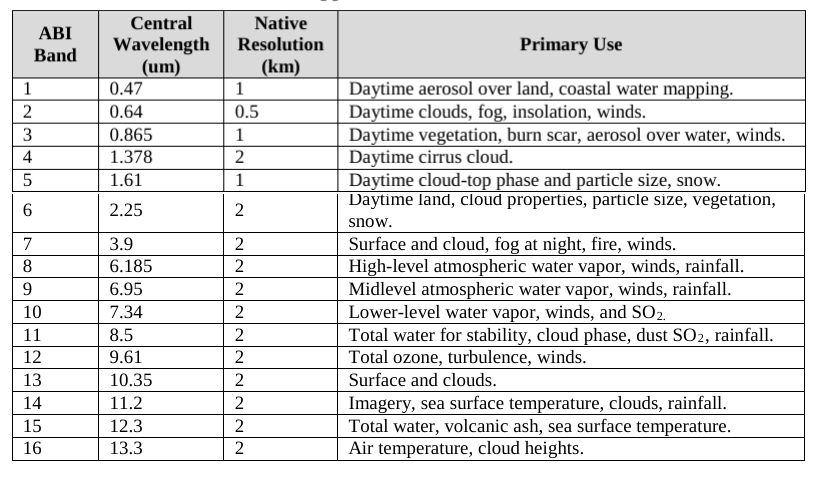

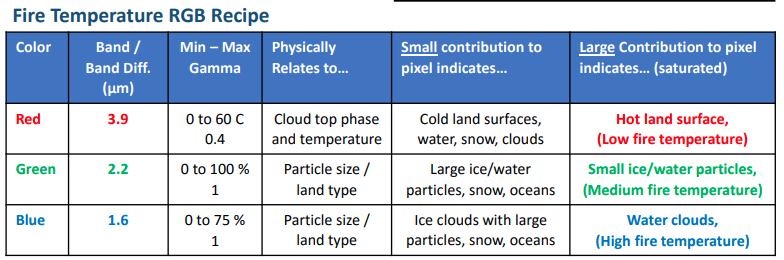

In [3]:
# Fire temperature RGB
dir_img = '../goes_fire'
image_list = sorted(os.listdir(dir_img))
images = [Dataset(os.path.join(dir_img, filename)) for filename in image_list]
metadato5 = images[0].variables
metadato6 = images[1].variables
metadato7 = images[2].variables

imagen5=metadato5['Rad'][::2,::2].data
imagen6=metadato6['Rad'][:].data
imagen7=metadato7['Rad'][:].data

imag_calibrate5 = calibrate_imag(imagen5, metadato5, 'Ref')
imag_calibrate6 = calibrate_imag(imagen6, metadato6, 'Ref')
imag_calibrate7  = calibrate_imag(imagen7, metadato7, 'T')

[filas,columnas] = imag_calibrate5.shape
imagen_RGB_fire= np.zeros([filas,columnas,3])
red_imagen = imag_calibrate7
green_imagen = imag_calibrate6
blue_imagen = imag_calibrate5
realce_red = realce_gama(red_imagen, 1, 2.5, 0, 60)
# Tuve que cambiar el valor de gamma dado en la receta por 1/0.4 = 2.5 ya que no coincidia con nuestra formula
realce_green = realce_gama(green_imagen,1, 1, 0, 1)
realce_blue = realce_gama(blue_imagen, 1, 1, 0, 0.75)

imagen_RGB_fire[:,:,0] = realce_red
imagen_RGB_fire[:,:,1] = realce_green
imagen_RGB_fire[:,:,2] = realce_blue

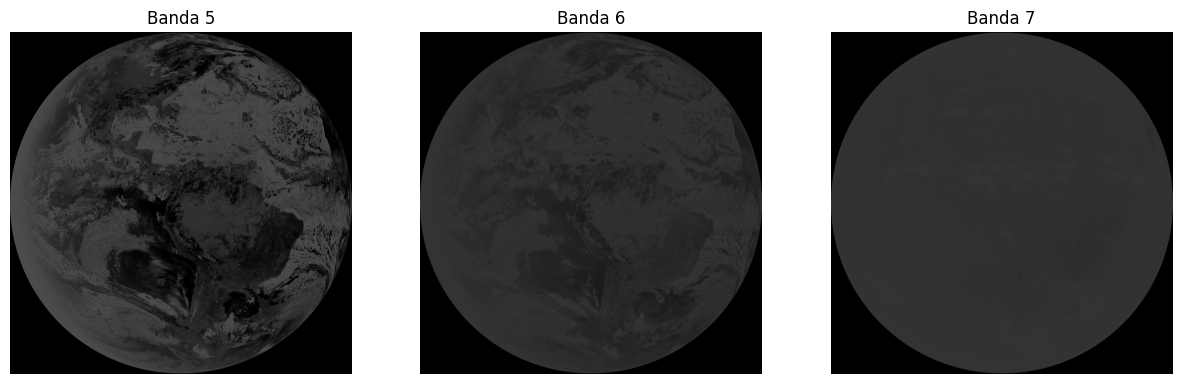

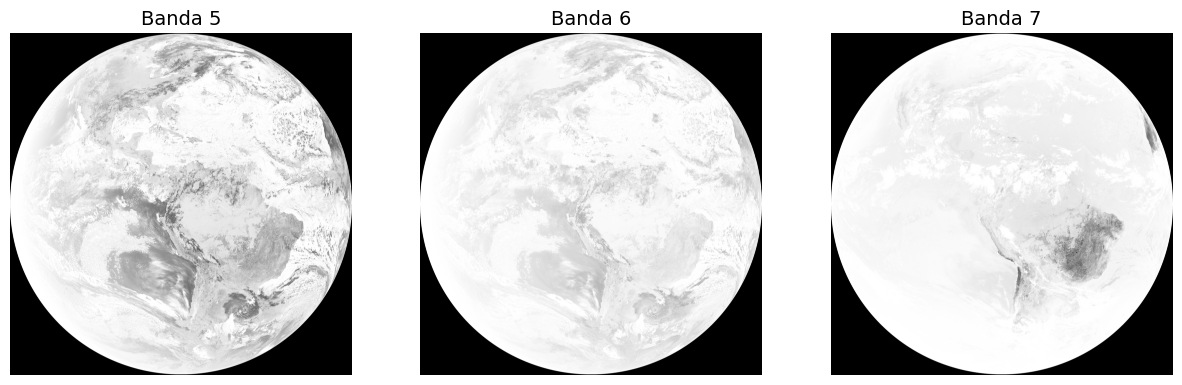

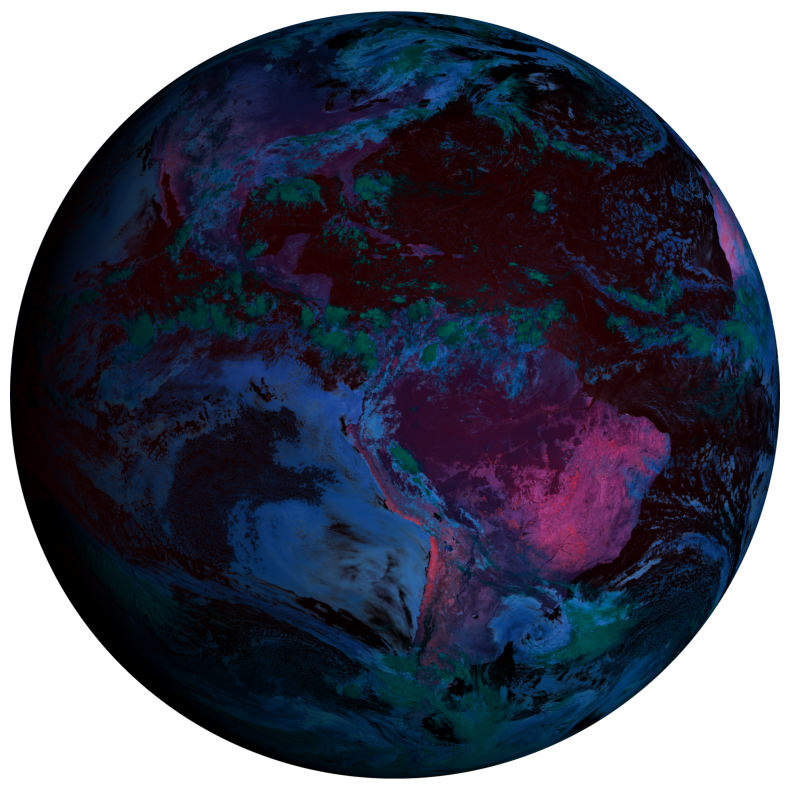

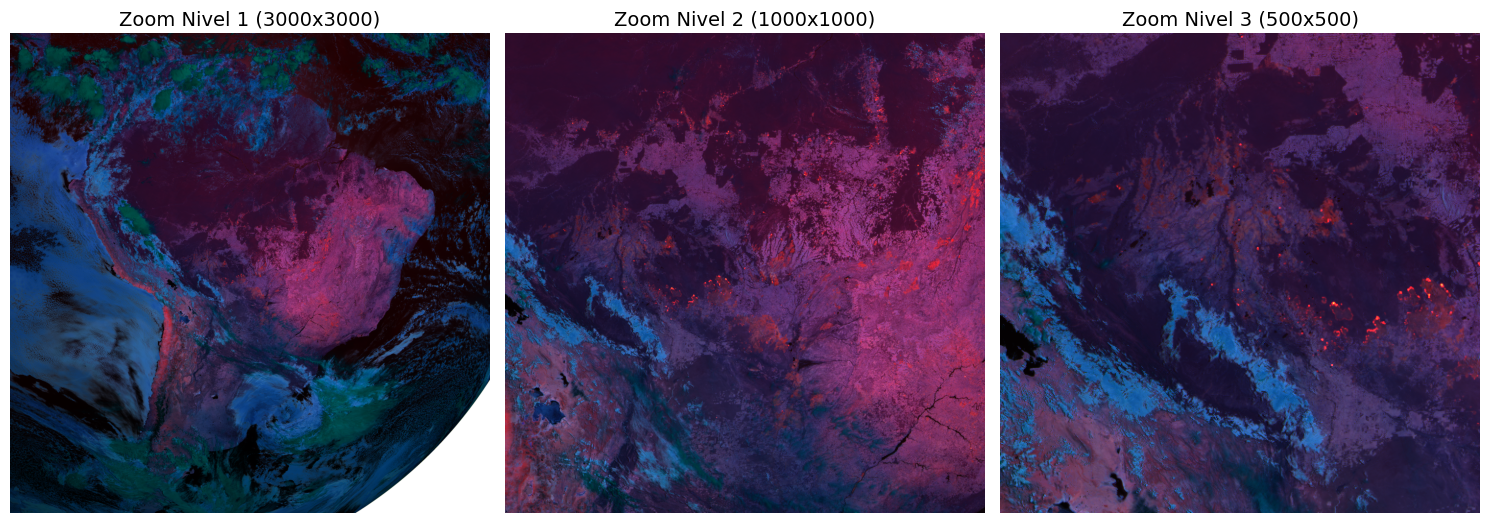

In [4]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(imagen5, vmin=-100, vmax=30, cmap='Greys')
plt.axis('off')
plt.title('Banda 5')
plt.subplot(1, 3, 2)
plt.imshow(imagen6, vmin=-100, vmax=20, cmap='Greys')
plt.axis('off')
plt.title('Banda 6')
plt.subplot(1, 3, 3)
plt.imshow(imagen7, vmin=-100, vmax=20, cmap='Greys')
plt.axis('off')
plt.title('Banda 7')
plt.show()

#Plot calibrated and gamma corrected bands
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(realce_blue, cmap='Greys')
plt.axis('off')
plt.title('Banda 5', fontsize=14)
plt.subplot(1, 3, 2)
plt.imshow(realce_green, cmap='Greys')
plt.axis('off')
plt.title('Banda 6', fontsize=14)
plt.subplot(1, 3, 3)
plt.imshow(realce_red, cmap='Greys')
plt.axis('off')
plt.title('Banda 7', fontsize=14)

#Plot RGB image
plt.figure(figsize=(10, 10))
plt.imshow(imagen_RGB_fire)
plt.axis('off')
plt.show()

show_amazonas(imagen_RGB_fire)

In [5]:
#VER VIDEO FULL DAY FIRE TEMP

In [6]:
# Cargar las bandas necesarias
dir_img = '../goes_true_color'
image_list = sorted(os.listdir(dir_img))
images = [Dataset(os.path.join(dir_img, filename)) for filename in image_list]
metadato1 = images[0].variables
metadato2 = images[1].variables
metadato3 = images[2].variables
imagen1 = metadato1['Rad'][::2,::2].data
imagen2 = metadato2['Rad'][::4,::4].data
imagen3 = metadato3['Rad'][::2,::2].data

imag_calibrate1 = calibrate_imag(imagen1, metadato1, 'Ref')  # Azul
imag_calibrate2 = calibrate_imag(imagen2, metadato2, 'Ref')  # Rojo
imag_calibrate3 = calibrate_imag(imagen3, metadato3, 'Ref')  # Verde
# Crear imagen RGB
[filas, columnas] = imag_calibrate1.shape
imagen_RGB_true_color = np.zeros((filas, columnas, 3))

# Asignar bandas con ajuste gamma
realce_red = realce_gama(imag_calibrate2, 1, 1, 0, 1)
realce_green = realce_gama(imag_calibrate3, 1, 1, 0, 1)
realce_blue = realce_gama(imag_calibrate1, 1, 1, 0, 1)

imagen_RGB_true_color[:, :, 0] = realce_red
imagen_RGB_true_color[:, :, 1] =  0.1 * realce_green + 0.45 * realce_red + 0.45 * realce_blue
imagen_RGB_true_color[:, :, 2] = realce_blue

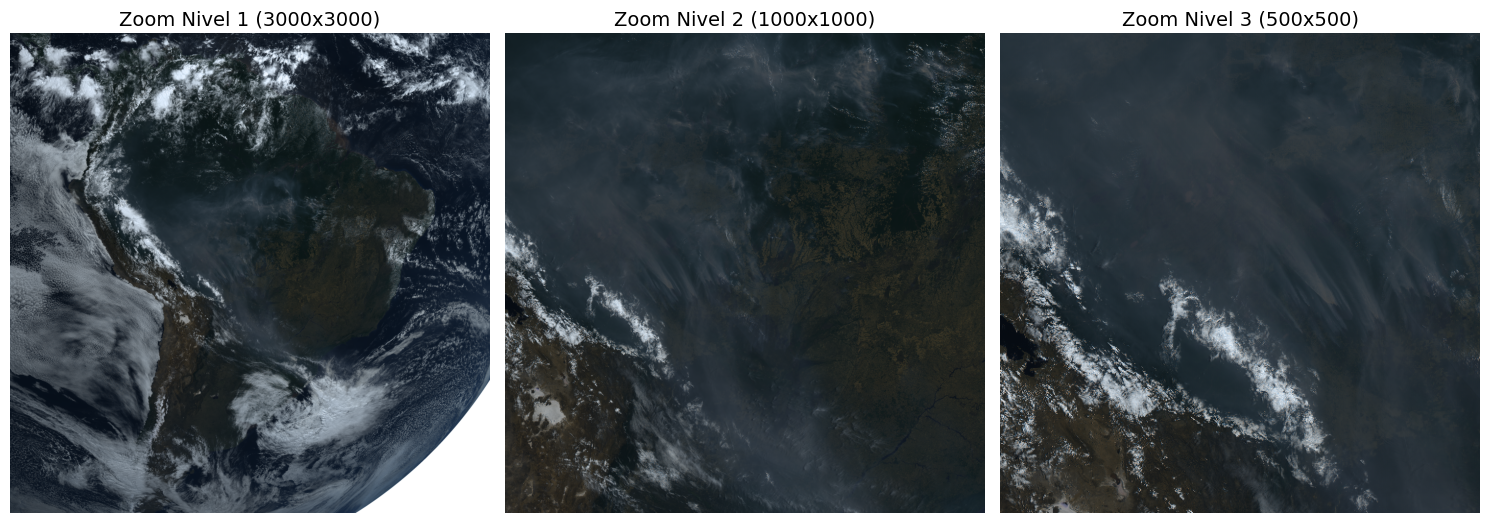

In [7]:
show_amazonas(imagen_RGB_true_color)

In [8]:
#VER VIDEO FULL DAY TRUE COLOR

# Analisis NDVI

## El codigo aqui es pseudocodigo, el codigo real se encuentra en el archivo NDVI.py

In [9]:
def calculate_ndvi(red_path, nir_path):
    """
    Calculates NDVI from red and near-IR bands and returns intermediate data for visualization.
    """
    with Dataset(red_path) as red_ds, Dataset(nir_path) as nir_ds:
        red_full = calibrate_imag(red_ds.variables['Rad'][::2,::2].data, red_ds.variables, 'Ref')
        nir_full = calibrate_imag(nir_ds.variables['Rad'][:].data, nir_ds.variables, 'Ref')

        tamaño = 800
        x0 = 7500
        y0 = 6200
        x1 = x0 + tamaño
        y1 = y0 + tamaño

        red = red_full[y0:y1, x0:x1]
        nir = nir_full[y0:y1, x0:x1]

        # Calculate NDVI
        ndvi = np.where(
            (nir + red) != 0,
            (nir - red) / (nir + red),
            0
        )
        
        return {
            'ndvi': ndvi,
            'red_full': red_full,
            'nir_full': nir_full
        }
    
def visualize_data(data_dict, title_prefix):
    """
    Creates comprehensive visualization of the data including full images,
    cropped region, and NDVI calculation.
    """
    fig = plt.figure(figsize=(20, 10))
    
    # Full resolution red band with crop box
    ax1 = plt.subplot(231)
    im1 = ax1.imshow(data_dict['red_full'], cmap='gray')
    x0, y0, x1, y1 = data_dict['crop_coords']
    rect = plt.Rectangle((y0, x0), y1-y0, x1-x0, fill=False, color='red')
    ax1.add_patch(rect)
    ax1.set_title(f'{title_prefix} - Full Red Band with Crop Region')
    plt.colorbar(im1, ax=ax1)

    # Full resolution NIR band with crop box
    ax2 = plt.subplot(232)
    im2 = ax2.imshow(data_dict['nir_full'], cmap='gray')
    rect = plt.Rectangle((y0, x0), y1-y0, x1-x0, fill=False, color='red')
    ax2.add_patch(rect)
    ax2.set_title(f'{title_prefix} - Full NIR Band with Crop Region')
    plt.colorbar(im2, ax=ax2)

    # Cropped red band
    ax3 = plt.subplot(234)
    im3 = ax3.imshow(data_dict['red_cropped'], cmap='gray')
    ax3.set_title(f'{title_prefix} - Cropped Red Band')
    plt.colorbar(im3, ax=ax3)

    # Cropped NIR band
    ax4 = plt.subplot(235)
    im4 = ax4.imshow(data_dict['nir_cropped'], cmap='gray')
    ax4.set_title(f'{title_prefix} - Cropped NIR Band')
    plt.colorbar(im4, ax=ax4)

    # NDVI result
    ax5 = plt.subplot(236)
    im5 = ax5.imshow(data_dict['ndvi'], cmap='RdYlGn', vmin=-1, vmax=1)
    ax5.set_title(f'{title_prefix} - NDVI')
    plt.colorbar(im5, ax=ax5)

    # Add histogram of NDVI values
    ax6 = plt.subplot(233)
    ax6.hist(data_dict['ndvi'].flatten(), bins=50, range=(-1, 1))
    ax6.set_title(f'{title_prefix} - NDVI Distribution')
    ax6.set_xlabel('NDVI Value')
    ax6.set_ylabel('Frequency')

    plt.tight_layout()
    return fig


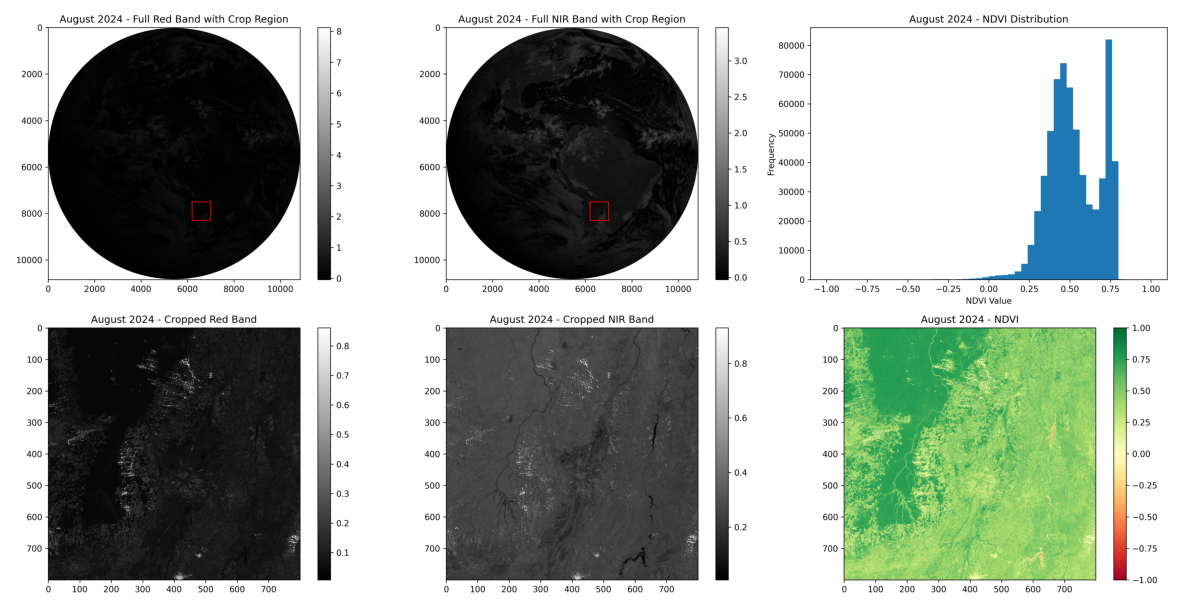

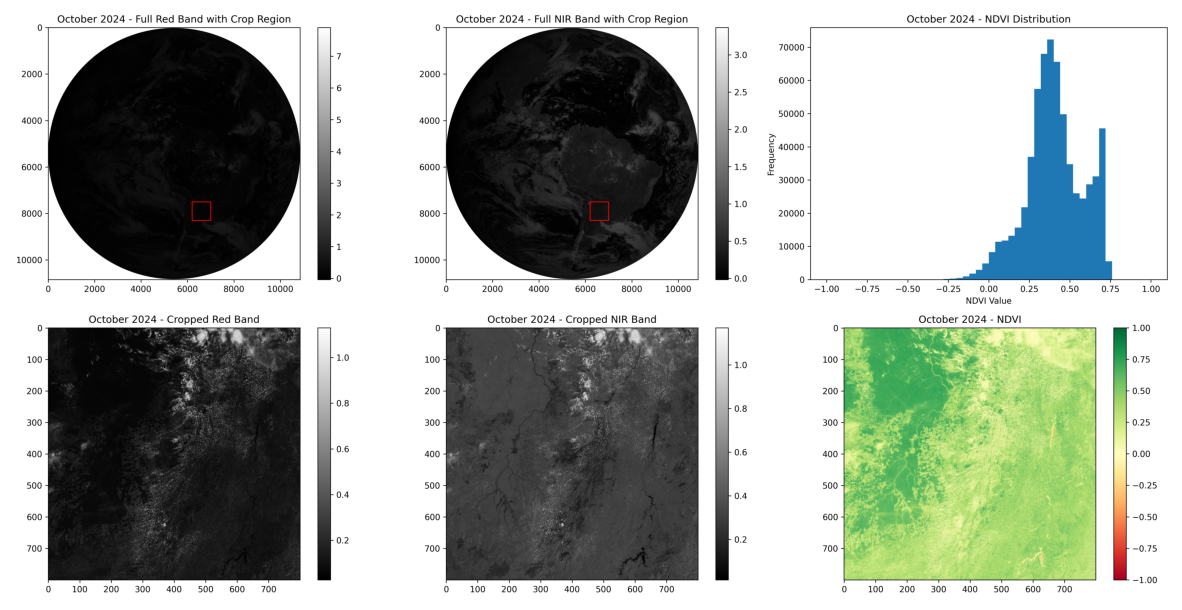

In [10]:
img = mpimg.imread("results/august_analysis.png")
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.axis("off")
plt.show()
img = mpimg.imread("results/october_analysis.png")
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.axis("off")
plt.show()

In [11]:
def visualize_comparison_with_fire(data_aug, data_dec, fire_data, save_path='ndvi_fire_comparison.png'):
    """
    Creates a comprehensive comparison including NDVI and fire temperature.
    """
    fig = plt.figure(figsize=(20, 10))
    
    # Primera fila: NDVI
    # August NDVI
    ax1 = plt.subplot(231)
    im1 = ax1.imshow(data_aug['ndvi'], cmap='RdYlGn', vmin=-1, vmax=1)
    ax1.set_title('August 2024 NDVI')
    plt.colorbar(im1, ax=ax1)
    
    # October NDVI
    ax2 = plt.subplot(232)
    im2 = ax2.imshow(data_dec['ndvi'], cmap='RdYlGn', vmin=-1, vmax=1)
    ax2.set_title('October 2024 NDVI')
    plt.colorbar(im2, ax=ax2)
    
    # NDVI Difference
    difference = data_dec['ndvi'] - data_aug['ndvi']
    ax3 = plt.subplot(233)
    im3 = ax3.imshow(difference, cmap='RdBu', vmin=-1, vmax=1)
    ax3.set_title('NDVI Difference (October - August)')
    plt.colorbar(im3, ax=ax3, label='NDVI Change')
    
    # Segunda fila: Fire Temperature y análisis adicional
    # Fire Temperature RGB
    ax4 = plt.subplot(234)
    im4 = ax4.imshow(fire_data['fire_rgb_crop'])
    ax4.set_title('September 1st Fire Temperature RGB')
    
    # Máscara de áreas afectadas
    ax5 = plt.subplot(235)
    affected_mask = (difference < -0.2).astype(float)
    im5 = ax5.imshow(affected_mask, cmap='Reds')
    ax5.set_title('Areas with Significant NDVI Decrease')
    plt.colorbar(im5, ax=ax5)
    
    # Histograma de diferencias
    ax6 = plt.subplot(236)
    ax6.hist(difference.flatten(), bins=50, range=(-1, 1), color='blue', alpha=0.7)
    ax6.set_title('NDVI Difference Distribution')
    ax6.set_xlabel('NDVI Change')
    ax6.set_ylabel('Frequency')
    
    # Añadir estadísticas
    stats_text = f"Mean difference: {np.mean(difference):.3f}\n"
    stats_text += f"Std difference: {np.std(difference):.3f}\n"
    stats_text += f"Max decrease: {np.min(difference):.3f}\n"
    stats_text += f"Max increase: {np.max(difference):.3f}\n"
    stats_text += f"Affected area: {np.mean(affected_mask)*100:.1f}%"
    
    plt.figtext(0.02, 0.02, stats_text, fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.suptitle('NDVI and Fire Temperature Analysis', fontsize=16)
    plt.tight_layout()
    return fig

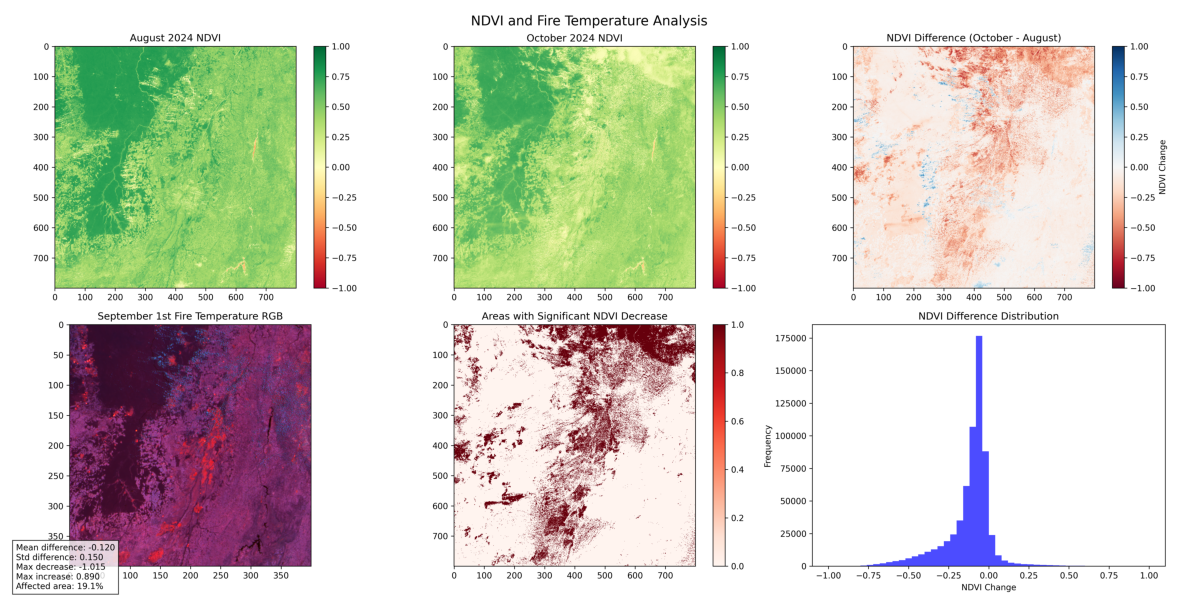

In [12]:
img = mpimg.imread("results/ndvi_fire_comparison.png")
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.axis("off")
plt.show()